In [ ]:
import linopy
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Primary Frequency Regulation for BESS example

- Read the frequency deviation file
- Assign a cost for each of the 4h block
- Assign an activation parameter depends on the frequency deviation

### Frequency deviation data

In [ ]:
f_deviation = pd.read_csv('germany_2020_01.csv.zip', index_col=0)



In [ ]:

f_deviation.index=pd.to_datetime(f_deviation.index) #set the index to panda datetime format

testday =f_deviation.loc[(f_deviation.index.day==1)] #select Jan 1st as the test day
testday=testday.bfill() #fill NaN with the next value
testday

Frequency
2020-01-01 00:00:00       25.0
2020-01-01 00:00:01       25.0
2020-01-01 00:00:02       24.0
2020-01-01 00:00:03       23.0
2020-01-01 00:00:04       22.0
...                        ...
2020-01-01 23:59:55       -5.0
2020-01-01 23:59:56       -7.0
2020-01-01 23:59:57       -8.0
2020-01-01 23:59:58       -9.0
2020-01-01 23:59:59      -10.0

[86400 rows x 1 columns]

In [ ]:
testday['Activation'] = testday['Frequency'].apply(lambda x: (0 if ((x<=20) & (x>=-20))  else 1))

In [ ]:
testhorizon=testday.loc[:'2020-01-01 23:59:59']
testhorizon

Frequency  Activation
2020-01-01 00:00:00       25.0           1
2020-01-01 00:00:01       25.0           1
2020-01-01 00:00:02       24.0           1
2020-01-01 00:00:03       23.0           1
2020-01-01 00:00:04       22.0           1
...                        ...         ...
2020-01-01 23:59:55       -5.0           0
2020-01-01 23:59:56       -7.0           0
2020-01-01 23:59:57       -8.0           0
2020-01-01 23:59:58       -9.0           0
2020-01-01 23:59:59      -10.0           0

[86400 rows x 2 columns]

### Battery Model

In [ ]:
BatteryCapacity = 4                     #MWh
BatteryPower= 1                         #MW
droop=BatteryPower/(500-20)
price=5

### Optimization Model

model = linopy.Model()
#Parameter
deltaf = testhorizon['Frequency'].to_xarray()
activation = testhorizon['Activation'].to_xarray()
#set variables
Pbatt = model.add_variables(lower= -BatteryPower, upper= BatteryPower, coords=deltaf.coords, name="Pbatt" ) 
#set constraints#     
load_con1= model.add_constraints(Pbatt <=BatteryPower, name="Battery power cannot be higher than load" )
load_con2= model.add_constraints(Pbatt >= (-BatteryPower), name="New load profile + battery power cannot excess the highest load")



lim=(Pbatt).rolling(index=len(testhorizon)).sum()




Battcapp=pd.Series(0.8*BatteryCapacity, index=deltaf).to_xarray()


expr0=lim <=0
expr1=(lim + 0.8*BatteryCapacity )>=0
Qmax_con = model.add_constraints(expr0, name="Qmax constraint")
Qmin_con = model.add_constraints(expr1, name="Qmin constraint")
Pmax_con1 = model.add_constraints(Pbatt <= BatteryPower, name="4h Battery charge") #not necessary
Pmax_con2 = model.add_constraints(Pbatt >= -BatteryPower, name="4h Battery discharge") #not necessary
droop_control = model.add_constraints(Pbatt <=(activation*droop*deltaf)) #droop control
#Costfunction
expr_cost=(price*Pbatt).sum()
model.add_objective(expr_cost)


#model.solve()

#Pbatt.solution


## Primary frequency control without optimization

### Battery Model

In [ ]:
Battery_Qmax = 4                     #MWh
Battery_Qmin = 0.2*Battery_Qmax
Battery_Pmax = 1                     #MW
Battery_Pop  = Battery_Pmax/2        #Maximum operation power of battery (max bidding)
Battery_iSOC  =50                         #assumed initial SOC is 50%
testhorizon['Pbatt']=0
testhorizon['SOC']  =0
testhorizon['DOD'] = 0

/tmp/ipykernel_1705759/1471125845.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testhorizon['Pbatt']=0
/tmp/ipykernel_1705759/1471125845.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testhorizon['SOC']  =0
/tmp/ipykernel_1705759/1471125845.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

### Operation Model

In [ ]:
time          =testhorizon.index
frequencydev  =testhorizon['Frequency']
Pbatt         =testhorizon['Pbatt']
Soc           =testhorizon['SOC']
DoD           =testhorizon['DOD']
currentSOC    =Battery_iSOC
droop=Battery_Pmax/(200)

for i in time:
    if ((frequencydev[i] > 10) & (frequencydev[i] <= 200)) or ((frequencydev[i] < (-10)) & (frequencydev[i] >= -200)): 
        if ((currentSOC*Battery_Qmax/100 > Battery_Qmin)) and ((currentSOC*Battery_Qmax/100) < Battery_Qmax):
            Pbatt[i] = (frequencydev[i])*droop
            #print(Pbatt[i])

        else:
            Pbatt[i]= 0
            #print(Pbatt[i])
    elif (frequencydev[i] > 200) or (frequencydev[i] < -200):
        Pbatt[i] = Battery_Pmax 
    else:
        if Battery_iSOC >= currentSOC:
            Pbatt[i]=min(((Battery_iSOC-currentSOC)*Battery_Qmax*3600), Battery_Pmax)
        else:
            Pbatt[i]=max(((Battery_iSOC-currentSOC)*Battery_Qmax*3600), (-Battery_Pmax))
    #print(frequencydev[i])
    
    Soc[i]=currentSOC + ((1/3600)*(Pbatt[i]))/Battery_Qmax
    DoD[i]=100-Soc[i]
    currentSOC=Soc[i]



        
        

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
testhorizon['Pbatt']= -Pbatt
testhorizon['SOC']= Soc

/tmp/ipykernel_1705759/3197940716.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1705759/3197940716.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
testhorizon
result = testhorizon.loc[:"2020-01-01 01:00:00"]

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


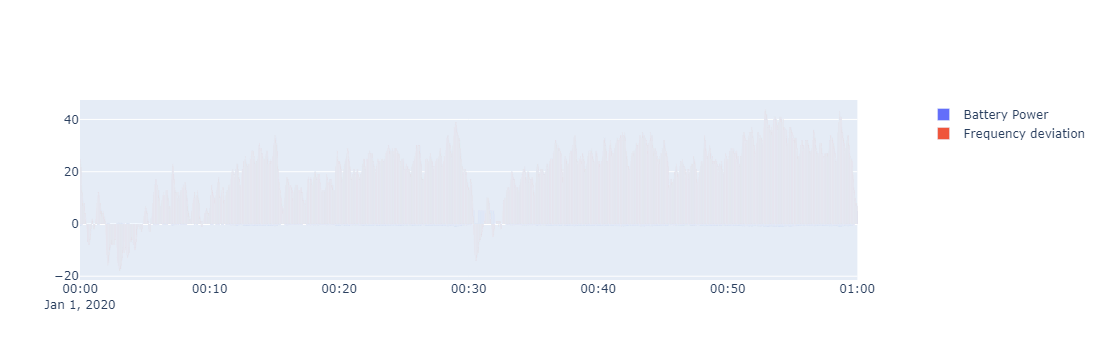

In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Bar(y=5*result['Pbatt'], x=result.index, 
                    name='Battery Power'),secondary_y=False)
fig.add_trace(go.Bar(x=result.index, y=result['Frequency'],
                        name='Frequency deviation'))
fig.show()

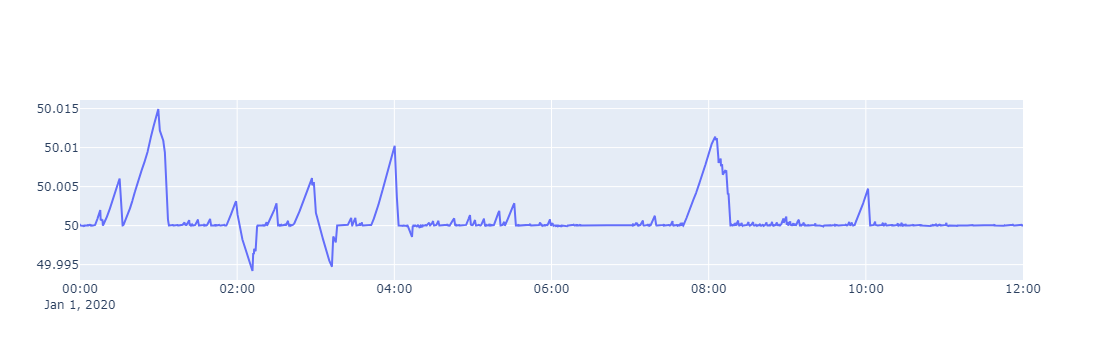

In [ ]:
SOC_fig= go.Figure()
SOC_fig.add_trace(go.Line(y=testhorizon['SOC'], x=testhorizon.index, 
                    name='Battery SOC'))
SOC_fig.show()